In [ ]:
from IPython.display import display
from IPython.display import HTML
import IPython.core.display as di # Example: di.display_html('<h3>%s:</h3>' % str, raw=True)

# This line will hide code by default when the notebook is exported as HTML
di.display_html('<script>jQuery(function() {if (jQuery("body.notebook_app").length == 0) { jQuery(".input_area").toggle(); jQuery(".prompt").toggle();}});</script>', raw=True)

# This line will add a button to toggle visibility of code blocks, for use with the HTML export version
di.display_html('''<button onclick="jQuery('.input_area').toggle(); jQuery('.prompt').toggle();">Toggle code</button>''', raw=True)



Exposure time: 5.0 s
JD UTC start exposue:  2458432.5963425925
JD UTC mid exposure:  2458432.5963715278
JD UTC end exposure:  2458432.596400463
JD Local computed:  2458432.2630092595
LST start:  13h26m58.4187s
LST mid:  13h27m00.9256s
LST end:  13h27m03.4324s
UTC start exposure:  2018-11-10 02:18:44.000
UTC mid exposure:  2018-11-10 02:18:46.500
UTC end exposure:  2018-11-10 02:18:49.000
JD Local computed:  2018-11-09T18:18:44.000
M57's Altitude: 2.5e+01 deg
M57 airmass is:  2.3841131138315568
M57's Hour Angle:  -5h27m18.5813s


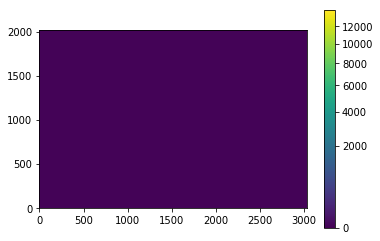

In [2]:
#
# code reads a M57 .fit file, (created by APT in this case),
# extracts the obs-date, exposure time, obj_ra, obj_dec
# site latitude and longitude, calculates its alt/az, airmass,
# local sidereal time from the date, time and site coordinates
# -egs- 3/6/19 
# sample files in ./M57,  shot 11/5/18 at WSO by egs

from __future__ import print_function
import os
from glob import glob

import astropy.units as u
from astropy.coordinates import SkyCoord, EarthLocation, AltAz, Angle, Latitude, Longitude
from astropy.io import fits
from astropy.time import Time
import time
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

%matplotlib inline

obj_center = SkyCoord.from_name('M57')

path = './M57/'
fit_files = glob(path + '*.fit')
# only do one
fits_image_filename = fit_files[0]

# fits.info(fits_image_filename)

# grab the header and the data from the .fits file
image_data, hdr = fits.getdata(fits_image_filename, header=True, ext=0)

# grab parameters from the hdr
date_obs = hdr['date-obs']
sitelong = hdr['sitelong']  # it's wrong in the header. APT bug

# for this exercise i'm correcting it by hand.
hdr['sitelong'] = '-121 48 32.4' # WSO

obj_ra = hdr['objctra']
obj_dec = hdr['objctdec']
exptime = hdr['exptime']
exposure_time = exptime*u.second

# convert the strings for ra and dec into actual angles
ra = Longitude(obj_ra, unit=u.hourangle)
dec = Latitude(obj_dec, unit=u.deg)

sitelong = hdr['sitelong']
sitelat = hdr['sitelat']
height = 60*u.m
site_location = EarthLocation(sitelong, sitelat, height=height)

utcoffset = -8*u.hour  # Pacific Standard Time

UTC_time_observation = Time(date_obs,format='fits',location=site_location)

local_time_observation = UTC_time_observation + utcoffset
local_time_observation.location = site_location
local_time_observation_mid = local_time_observation + exposure_time / 2
local_time_observation_end = local_time_observation + exposure_time

UTC_mid_exposure_time = UTC_time_observation + exposure_time / 2
UTC_end_exposure_time = UTC_time_observation + exposure_time

sidereal_time_local_start = local_time_observation.sidereal_time('apparent') 
sidereal_time_local_mid = local_time_observation_mid.sidereal_time('apparent') 
sidereal_time_local_end = local_time_observation_end.sidereal_time('apparent') 

print('Exposure time:', exposure_time)
print('JD UTC start exposue: ',UTC_time_observation.jd)
print('JD UTC mid exposure: ', UTC_mid_exposure_time.jd)
print('JD UTC end exposure: ', UTC_end_exposure_time.jd)
print('JD Local computed: ', local_time_observation.jd)
print('LST start: ', sidereal_time_local_start)
print('LST mid: ', sidereal_time_local_mid)
print('LST end: ', sidereal_time_local_end)
print('UTC start exposure: ', UTC_time_observation.iso)
print('UTC mid exposure: ', UTC_mid_exposure_time.iso)
print('UTC end exposure: ', UTC_end_exposure_time.iso)
print('JD Local computed: ', local_time_observation)

object_observed_camera = SkyCoord(ra,dec,obstime=date_obs)
object_altaz_camera = object_observed_camera.transform_to(AltAz(obstime=local_time_observation,
                                                  location=site_location))
print("M57's Altitude: {0.alt:.2}".format(object_altaz_camera))

airmass = object_altaz_camera.secz
print('M57 airmass is: ', airmass)

hourangle = sidereal_time_local_start - object_observed_camera.ra
print("M57's Hour Angle: ", hourangle)

##################

from astropy.visualization import (MinMaxInterval, SqrtStretch,
                                   ImageNormalize,PercentileInterval)

# Create an ImageNormalize object
norm = ImageNormalize(image_data, interval=MinMaxInterval(),
                      stretch=SqrtStretch())
transform = SqrtStretch()
stretched = transform(image_data)
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
im = ax.imshow(stretched, origin='lower', norm=norm)
fig.colorbar(im)



In [3]:
#
# working with actual fit files from the Axiom at Chews Ridge
# code reads Light .fits frames from a specified path, 
# extracts the obs-date, exposure time, airmass, time start, object.
# The program computes the time mid, time end
# in UTC and LST by using the coordinates of Chews Ridge
# 
# -egs- 3/6/19 

from glob import glob
import os

import astropy.units as u
import astropy.coordinates as coord
from astropy.coordinates import SkyCoord, EarthLocation, AltAz
from astropy.io import fits
from astropy.time import Time
import time

# OOS coordinates taken from Google Earth
sitelong = '-121 34 1'
sitelat = '36 18 20'
height = 1516*u.m
site_location = EarthLocation(sitelong, sitelat, height=height)

utcoffset = -8*u.hour

#fit_files = os.listdir(path)

# grab only the light frames. this command produces a list of files matching
# the string L*.fits
path = './PHOT030727/A/'
files = glob(path + 'L*.fits')

start_time = time.time()

for fits_image_file in files:
    data, hdr = fits.getdata(fits_image_file, header=True)
    # the following updates the file with the site lat and long
    hdr['SITELAT'] = sitelat
    hdr['SITELONG'] = sitelong
    
    # grab parameters from the hdr
    date_obs = hdr['date-obs']
    exptime = hdr['exptime']
    obj_name = hdr['object']
    exposure_time = exptime*u.second
    airmass = hdr['airmass']

    # Do the time calculations
    UTC_time_observation = Time(date_obs,format='fits',location=site_location)
    UTC_mid_exposure_time = UTC_time_observation + exposure_time / 2
    UTC_end_exposure_time = UTC_time_observation + exposure_time

    local_time_observation = UTC_time_observation + utcoffset
    local_time_observation_mid = local_time_observation + exposure_time / 2
    local_time_observation_end = local_time_observation + exposure_time
    local_time_observation.location = site_location
    
    sidereal_time_local_start = local_time_observation.sidereal_time('apparent') 
    sidereal_time_local_mid = local_time_observation_mid.sidereal_time('apparent') 
    sidereal_time_local_end = local_time_observation_end.sidereal_time('apparent') 

    print('File:                      ', fits_image_file)
    print('Object:                    ', obj_name)
    print('Exposure:                  ', exposure_time)
    print('Airmass:                   ', airmass)
    print('JD UTC start exposue:      ', UTC_time_observation.jd)
    print('JD UTC mid exposure:       ', UTC_mid_exposure_time.jd)
    print('JD UTC end exposure:       ', UTC_end_exposure_time.jd)
    print('Local Time start exposure: ', local_time_observation.iso)
    print('Local Time mid exposure:   ', local_time_observation_mid.iso)
    print('Local Time end exposure:   ', local_time_observation_end.iso)
    print('LST start:                 ', sidereal_time_local_start)
    print('LST mid:                   ', sidereal_time_local_mid)
    print('LST end:                   ', sidereal_time_local_end)
    print('UTC start exposure:        ', UTC_time_observation.iso)
    print('UTC mid exposure:          ', UTC_mid_exposure_time.iso)
    print('UTC end exposure:          ', UTC_end_exposure_time.iso)
    print('--------------------------------------------------')
    fits.writeto(fits_image_file, data, hdr, overwrite=True)

end_time = time.time()
elapsed_time = (end_time - start_time)*u.s

print('Elapsed time: ', elapsed_time)

File:                       ./PHOT030727/A/L110_5.fits
Object:                     Landolt 110a
Exposure:                   180.0 s
Airmass:                    2.14
JD UTC start exposue:       2452848.9205658566
JD UTC mid exposure:        2452848.921607523
JD UTC end exposure:        2452848.92264919
Local Time start exposure:  2003-07-28 02:05:36.890
Local Time mid exposure:    2003-07-28 02:07:06.890
Local Time end exposure:    2003-07-28 02:08:36.890
LST start:                  14h20m40.7898s
LST mid:                    14h22m11.0362s
LST end:                    14h23m41.2826s
UTC start exposure:         2003-07-28 10:05:36.890
UTC mid exposure:           2003-07-28 10:07:06.890
UTC end exposure:           2003-07-28 10:08:36.890
--------------------------------------------------
File:                       ./PHOT030727/A/L110_4.fits
Object:                     Landolt 110a
Exposure:                   180.0 s
Airmass:                    1.472
JD UTC start exposue:       2452848.860